In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pycaret.classification import *

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from matplotlib.colors import ListedColormap


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pycaret.regression import *
from sklearn.metrics import silhouette_samples, silhouette_score
import math
import random
import matplotlib.ticker as mtick
import re

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error


from neighborhoods import admin_wards
from neighborhoods import district_neighborhoods

In [2]:
random.seed(42)

In [3]:
# Load the dataset
df = pd.read_csv('../data/processed/additional_data_cluster_0.csv')
# df = pd.read_csv('../data/processed/additional_data_cleaned_ER.csv')

df = df.dropna()
df.shape

(12515, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12008 entries, 0 to 12974
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  12008 non-null  int64  
 1   house_type             12008 non-null  object 
 2   house_type_2           12008 non-null  object 
 3   rooms                  12008 non-null  int64  
 4   m2                     12008 non-null  float64
 5   elevator               12008 non-null  int64  
 6   garage                 12008 non-null  int64  
 7   neighborhood           12008 non-null  object 
 8   district               12008 non-null  object 
 9   parking_spaces         12008 non-null  float64
 10  education_centers      12008 non-null  float64
 11  sports_centers         12008 non-null  float64
 12  social_wellness_index  12008 non-null  float64
 13  urban_mobility_index   12008 non-null  float64
 14  education_index        12008 non-null  float64
 15  em

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [9]:
df_corr = pd.DataFrame(df[numerical_features].corr()['price'])
df_corr['price'] = df_corr['price'].apply(lambda x: abs(x))
df_corr.sort_values(by='price', ascending=False)

,price
price,1.000000
m2,0.784822
employment_index,0.542900
education_index,0.472282
elevator,0.413287
rooms,0.404959
garage,0.239010
urban_mobility_index,0.216600
parking_spaces,0.207862
social_wellness_index,0.164587


In [10]:
df = df[[column for column in df.columns if column != 'sports_centers' 
        and column != 'education_centers' 
        and column != 'health_index'
        and column != 'social_wellness_index'
        ]]

In [11]:
df['log_price'] = np.log(df['price'])
df = df.drop(columns = 'price')

In [12]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [13]:
df_corr = pd.DataFrame(df[numerical_features].corr()['log_price'])
df_corr['log_price'] = df_corr['log_price'].apply(lambda x: abs(x))
df_corr.sort_values(by='log_price', ascending=False)

,log_price
log_price,1.000000
m2,0.759940
employment_index,0.633325
education_index,0.554978
elevator,0.513946
rooms,0.396363
garage,0.296667
urban_mobility_index,0.222996
parking_spaces,0.218742


In [14]:
# Define features and target variable
X = df[[column for column in df.columns if column != 'log_price']]
y = df['log_price']

In [15]:
# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Initialize models
logistic_regression_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

ridge_classifier_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RidgeClassifier())
])

lasso_logistic_regression_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(penalty='l1', solver='saga'))
])

elastic_net_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])


In [16]:
# Setup the environment in PyCaret
regression_setup = setup(
    data=df,
    target = 'log_price',
    ignore_features=[],
    numeric_imputation = 'mean',
    categorical_imputation = 'mode',
    remove_multicollinearity=True,
    # transformation= True,
    # transformation_method = 'yeo-johnson',
    normalize = True,
    normalize_method = 'zscore',
    session_id=42,
    fold_strategy='kfold',
    fold=5,
)

,Description,Value
0,Session id,42
1,Target,log_price
2,Target type,Regression
3,Original data shape,"(12008, 13)"
4,Transformed data shape,"(12008, 33)"
5,Transformed train set shape,"(8405, 33)"
6,Transformed test set shape,"(3603, 33)"
7,Numeric features,8
8,Categorical features,4
9,Preprocess,True


In [17]:
# compare baseline models
best_model = compare_models(exclude=['lar', 'lr'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.1499,0.0428,0.2064,0.9051,0.0156,0.0119,0.3760
lightgbm,Light Gradient Boosting Machine,0.1535,0.0438,0.2087,0.9029,0.0158,0.0122,0.5640
xgboost,Extreme Gradient Boosting,0.1569,0.0473,0.2169,0.8952,0.0164,0.0125,0.0440
rf,Random Forest Regressor,0.1563,0.0480,0.2185,0.8936,0.0165,0.0124,0.2600
gbr,Gradient Boosting Regressor,0.1635,0.0486,0.2200,0.8922,0.0165,0.0130,0.1200
et,Extra Trees Regressor,0.1584,0.0531,0.2299,0.8823,0.0177,0.0126,0.1980
ridge,Ridge Regression,0.1806,0.0585,0.2415,0.8703,0.0180,0.0143,0.2620
br,Bayesian Ridge,0.1806,0.0585,0.2414,0.8703,0.0180,0.0143,0.0280
huber,Huber Regressor,0.1802,0.0585,0.2414,0.8703,0.0180,0.0143,0.0260
knn,K Neighbors Regressor,0.1888,0.0661,0.2568,0.8533,0.0192,0.0150,0.0480


In [18]:
n_iter=50

# print('Tune Model:')
# best_model = tune_model(best_model, n_iter=n_iter, choose_better=True)

# print('Tune Model - optuna:')
# best_model = tune_model(best_model, search_library = 'optuna', n_iter=n_iter, choose_better=True)

# print('Tune Model - scikit-optimize:')
# best_model = tune_model(best_model, search_library = 'scikit-optimize', n_iter=n_iter, choose_better=True)

# print('Bagging:')
# best_model = ensemble_model(best_model, method = 'Bagging', choose_better=True)

# print('Boosting:')
# best_model = ensemble_model(best_model, method = 'Boosting', choose_better=True)

print('Top 3 Models:')
best_mae_models_top3 = compare_models(sort = 'MAE', n_select = 3, exclude=['lar', 'lr'])

# print('Blending:')
# best_model = blend_models(best_mae_models_top3, choose_better=True)

print('Stacking:')
best_model = stack_models(best_mae_models_top3, choose_better=True)

Top 3 Models:


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.1499,0.0428,0.2064,0.9051,0.0156,0.0119,0.3740
lightgbm,Light Gradient Boosting Machine,0.1535,0.0438,0.2087,0.9029,0.0158,0.0122,0.5460
rf,Random Forest Regressor,0.1563,0.0480,0.2185,0.8936,0.0165,0.0124,0.2360
xgboost,Extreme Gradient Boosting,0.1569,0.0473,0.2169,0.8952,0.0164,0.0125,0.0400
et,Extra Trees Regressor,0.1584,0.0531,0.2299,0.8823,0.0177,0.0126,0.2000
gbr,Gradient Boosting Regressor,0.1635,0.0486,0.2200,0.8922,0.0165,0.0130,0.1180
huber,Huber Regressor,0.1802,0.0585,0.2414,0.8703,0.0180,0.0143,0.0260
br,Bayesian Ridge,0.1806,0.0585,0.2414,0.8703,0.0180,0.0143,0.0260
ridge,Ridge Regression,0.1806,0.0585,0.2415,0.8703,0.0180,0.0143,0.0220
knn,K Neighbors Regressor,0.1888,0.0661,0.2568,0.8533,0.0192,0.0150,0.0400


Stacking:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1550,0.0414,0.2036,0.9072,0.0150,0.0122
1,0.1483,0.0553,0.2351,0.8809,0.0194,0.0120
2,0.1483,0.0386,0.1964,0.9144,0.0144,0.0117
3,0.1503,0.0388,0.1969,0.9114,0.0145,0.0119
4,0.1464,0.0375,0.1937,0.9173,0.0143,0.0116
Mean,0.1497,0.0423,0.2051,0.9062,0.0155,0.0119
Std,0.0030,0.0066,0.0153,0.0131,0.0020,0.0002


In [19]:
holdout_pred = predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,0.1434,0.0377,0.1941,0.9171,0.0143,0.0114


In [20]:
holdout_pred.describe()

,rooms,m2,elevator,garage,parking_spaces,urban_mobility_index,education_index,employment_index,log_price,prediction_label
count,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000
mean,2.548154,95.674438,0.712184,0.247294,894.096313,8.793242,7.640894,7.878468,12.670527,12.674233
std,0.979296,42.912868,0.452808,0.431499,882.599976,6.518955,2.873236,2.888003,0.673927,0.639756
min,1.000000,20.000000,0.000000,0.000000,0.000000,3.060000,2.430000,3.810000,10.915089,11.285418
25%,2.000000,64.000000,0.000000,0.000000,125.000000,5.460000,5.250000,5.390000,12.100712,12.137488
50%,3.000000,86.000000,1.000000,0.000000,512.000000,6.810000,6.630000,7.240000,12.611538,12.617739
75%,3.000000,119.000000,1.000000,0.000000,1635.000000,9.240000,10.580000,9.990000,13.171153,13.180105
max,5.000000,242.000000,1.000000,1.000000,3560.000000,56.340000,14.080000,17.500000,14.200773,14.109186


In [21]:
holdout_pred['price'] = np.exp(holdout_pred['log_price'])
holdout_pred['predicted_price'] = np.exp(holdout_pred['prediction_label'])

In [22]:
actual_prices = holdout_pred['price']
predicted_prices = holdout_pred['predicted_price']
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
rmse, mae

(90254.38134134524, 56597.38917614746)

In [23]:
RMSE = np.sqrt(mean_squared_error(holdout_pred['log_price'], holdout_pred['prediction_label']))
RMSE/(holdout_pred['log_price'].max() - holdout_pred['log_price'].min())

0.05906500980823001

In [24]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

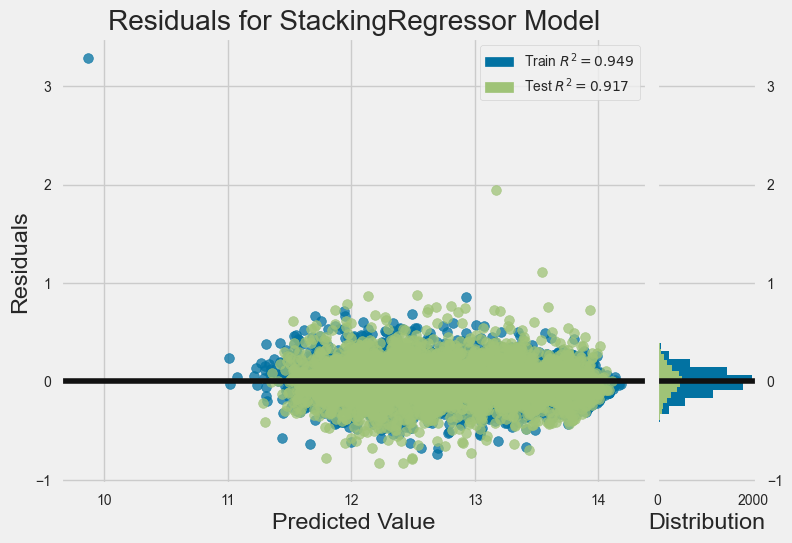

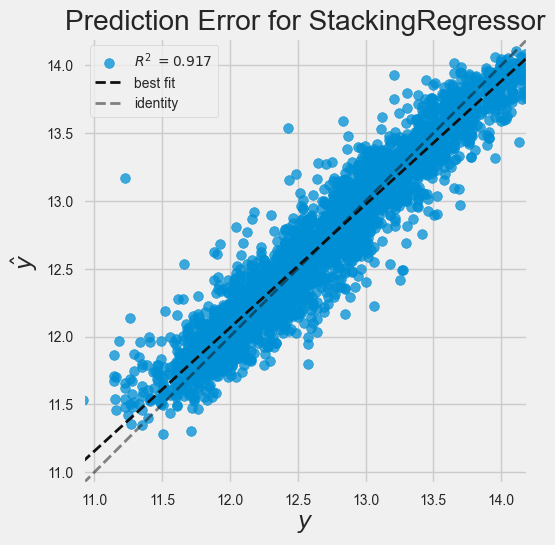

In [25]:
plot_model(best_model, plot = 'residuals', fold=10)

plot_model(best_model, plot = 'error')

# plot_model(best_model, plot = 'feature')

# plot_model(best_model, plot = 'learning')

<Axes: >

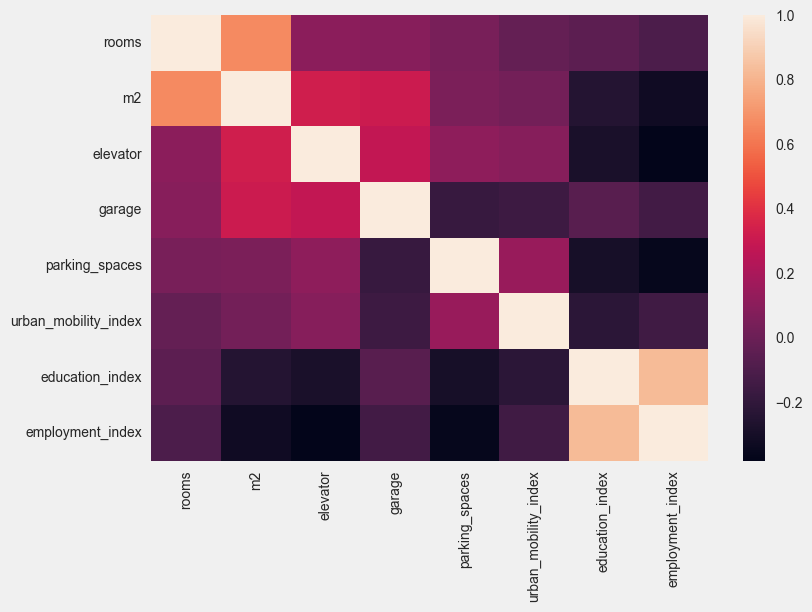

In [26]:
sns.heatmap(df[numerical_features].corr())